# Выпускной проект




**Описание проекта: промышленность** 

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

Описание этапа обработки


Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).


Файл data_arc_new.csv

- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.


Файл data_bulk_new.csv

- кey — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.


Файл data_bulk_time_new.csv

- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.


Файл data_gas_new.csv

- key — номер партии;
- Газ 1 — объём подаваемого газа.


Файл data_temp_new.csv

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.


Файл data_wire_new.csv

- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.


Файл data_wire_time_new.csv

- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они 
соответствуют разным итерациям обработки.

**Описание цели проекта**


Целевая переменная target - последняя температура по всей партии

Целевая метрика - MAE (нужно получить не более 6.8 на тесте)


**Ход исследования в проекте:**


- [Загрузка и изучение данных](#section_id): общая информация о датасетах, опредение соответствуют ли данные описанию задачи и стандартам оформления данных. 
- [Предобработка данных](#section_id1): обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
- [Исследовательский анализ данных](#section_id2): статистический анализ всех признаков, графики для каждого признака, их распределения, зависимости, а также выявление аномалий.
- [Объединение данных](#section_id3): объединение выбранных нами признаки в один датафрейм по ключу.
- [Корреляционный анализ и исследовательский анализ данных единого датасета](#section_id4): проведение корреляционного анализа признаков в итоговой таблице для моделирования, выводы о наличии или об отсутствии мультиколлинеарности.
- [Подготовка данных для обучения](#section_id5): создание пайплайнов для подготовки данных, отбор признаков.
- [Обучение моделей](#section_id6): обучение разных моделей, выбор лучшей на основании лучшего показателя выбранной метрики метрики.
- [Общий вывод](#section_id7): что сделали для поиска лучшей модели, как она может помочь бизнесу, рекомендации для бизнеса.

<a id='section_id'></a>
### Загрузка и изучение данных.

Импортируем необходимые библиотеки. Далее выведем общую информацию о каждом датасете, посмотрим первые пять строк для понимания структуры данных.

In [1]:
!pip install -Uq scikit-learn

In [2]:
!pip install phik -q

In [3]:
!pip install shap -q

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.metrics import r2_score, mean_absolute_error
   

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from phik.report import correlation_report, plot_correlation_matrix


import shap

In [5]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [6]:
pd.set_option('display.max_columns', None)

Создадим функцию для вывода общей информации, пропусках, дубликатах.

In [7]:
def general_info(x):
    print('------------- Первые пять строк датафрейма -------------')
    display(x.head())
    print('')
    print('')
    print('------------- Общая информация о датафрейме -------------')
    print('')
    print('')
    x.info()
    print('------------- Количество пустых значений в датафрейме -------------')
    print('')
    print('')
    display(x.isna().sum())
    print('------------- Количество явных дубликатов в датафрейме -------------')
    print('')
    print('')
    display(x.duplicated().sum())

**Данные об электродах**

In [8]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')

In [9]:
general_info(data_arc)

------------- Первые пять строк датафрейма -------------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
------------- Количество пустых значений в датафрейме -------------




key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

Приведем названия столбцов к общепринятому виду.

In [10]:
data_arc.columns = [col.lower().replace(' ', '_') for col in data_arc.columns]

In [11]:
data_arc.columns

Index(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность'],
      dtype='object')

В данных нет пропусков и явных дубликатов. Типы данных соответствуют задачам за исключением времени начала нагрева и конца нагрева. Приведем эти данные к типу дата время, поскольку скорее всего нам понадобятся временные дельты между нагревами дугой.

In [12]:
data_arc[['начало_нагрева_дугой', 'конец_нагрева_дугой']] = data_arc[['начало_нагрева_дугой', 'конец_нагрева_дугой']].\
apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [13]:
data_arc['key'].nunique()

3214

**Данные о подаче сыпучих материалов (объём)**

In [14]:
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')

In [15]:
general_info(data_bulk_new)

------------- Первые пять строк датафрейма -------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
------------- Количество пустых значений в датафрейме -------------




key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

Приведем названия столбцов к общепринятому виду.

In [16]:
data_bulk_new.columns = [col.lower().replace(' ', '_') for col in data_bulk_new.columns]
data_bulk_new.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Видим, что в данных очень много пропусков. Скорее всего это связано с тем, что на какой-то стадии сыпучие материалы не подавались. Что делать с этими пропусками мы решим позднее на стадии подготовки финального датасета для обучения модели.

**Данные о подаче сыпучих материалов (время)**

In [17]:
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [18]:
general_info(data_bulk_time)

------------- Первые пять строк датафрейма -------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
------------- Количество пустых значений в датафрейме -------------




key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

Приведем названия столбцов к общепринятому виду.

In [19]:
data_bulk_time.columns = [col.lower().replace(' ', '_') for col in data_bulk_time.columns]
data_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Видим, что количество пропусков абсолютно совпадает с пропусками в объеме подаваемых сыпучих материалов. Пока оставим эти пропуски, а далее по мере решения задачи решим, что с ними делать. 
На данном этапе приведем столбцы к типу дата-время.

In [20]:
data_bulk_time[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']] = \
data_bulk_time[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

**Данные о продувке сплава газом**

In [21]:
data_gas = pd.read_csv('/datasets/data_gas_new.csv')

In [22]:
general_info(data_gas)

------------- Первые пять строк датафрейма -------------


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
------------- Количество пустых значений в датафрейме -------------




key      0
Газ 1    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

Приведем названия столбцов к общепринятому виду.

In [23]:
data_gas.columns = [col.lower().replace(' ', '_') for col in data_gas.columns]
data_gas.columns

Index(['key', 'газ_1'], dtype='object')

Пропуски отсутствуют. Тип данных соответствует задачам.

**Результаты измерения температуры**

In [24]:
data_temp = pd.read_csv('/datasets/data_temp_new.csv')

In [25]:
general_info(data_temp)

------------- Первые пять строк датафрейма -------------


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
------------- Количество пустых значений в датафрейме -------------




key                0
Время замера       0
Температура     3427
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

Приведем названия колонок к общепринятому виду

In [26]:
data_temp.columns = [col.lower().replace(' ', '_') for col in data_temp.columns]
data_temp.columns

Index(['key', 'время_замера', 'температура'], dtype='object')

Приведем время замера к типу данных дата-время.

In [27]:
data_temp['время_замера'] = pd.to_datetime(data_temp['время_замера'], format='%Y-%m-%d %H:%M:%S')

В данных много пропусков по столбцу температуры. Очевидно, что в какие-то моменты времени температура попросту не измерялась. Пока не будем заполнять эти пропуски, так как температура является целевой переменной. Скорее всего мы просто отбросим эти пропуски.

**Данные о проволочных материалах (объём)**

In [28]:
data_wire = pd.read_csv('/datasets/data_wire_new.csv')

In [29]:
general_info(data_wire)

------------- Первые пять строк датафрейма -------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
------------- Количество пустых значений в датафрейме -------------




key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

Приведем названия столбцов к общепринятому виду.

In [30]:
data_wire.columns = [col.lower().replace(' ', '_') for col in data_wire.columns]
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Видим, что в данных много пропусков. Скорее всего в какие-то моменты времени проволока не добавлялась. Что делать с этими пропусками мы решим позднее на стадии подготовки финального датасета для обучения модели.

**Данные о проволочных материалах (время)**

In [31]:
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [32]:
general_info(data_wire_time)

------------- Первые пять строк датафрейма -------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
------------- Количество пустых значений в датафрейме -------------




key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

Приведем названия столбцов к общепринятому виду.

In [33]:
data_wire_time.columns = [col.lower().replace(' ', '_') for col in data_wire_time.columns]
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Видим, что количество пропусков абсолютно соответствует пропускам в данных об объеме проволки. Очевидно, что в какие-то моменты времени проволока не подавалась. Пока оставим эти пропуски и далее по мере решения задачи решим, что с этим делать. А пока приведем тип данных к типу дата-время

In [34]:
data_wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']] = \
data_wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

**Промежуточный вывод по разделу**

Загрузили данные из семи датасетов, ознакомились с общей структурой данных. Проверили типы данных, пропуски и явные дубликаты. Провели промежуточную предварительную подготовку данных, а именно - привели данные о времени к типу дата-время, пропуски пока оставили. Привели все названия столбцов к общепринятому виду.

<a id='section_id1'></a>
### Предобработка данных.

Проведем предварительный исследовательский анализ каждого датасета, посмотрим на описательную статистику, проверим наличие аномалий, посмотрим на распределения данных. Далее после сведения информации в единый датафрейм мы проведем снова исследовательский анализ, но более углубленный, посмотрим корреляцию признаков, построим графики зависимостей целевой переменной от входящих признаков. 
Для первичного анализа напишем функцию. 

In [35]:
def eda(data):
    print('------------- Описательная статистика для числовых данных -------------')
    display(data.describe())
    print('')
    print('')
    print('------------- Гистограммы для числовых признаков -------------')
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_features.remove('key')
    for i in numeric_features:
        f, (ax_box, ax_hist) = plt.subplots(2, figsize=(10, 7))
        
        sns.boxplot(x=data[i].dropna(), orient="h", ax=ax_box)
        ax_box.set_title(f'Распределение {i}', loc='left')
        ax_box.set_xlabel(f'{i}')
        ax_box.set_ylabel('Частота')
        
        plt.subplots_adjust(hspace=0.5)
        
        ax_hist.hist(data[i].dropna(), bins=100)
        plt.grid(True)
        plt.title(f'Распределение {i}', loc='left')
        plt.xlabel(f'{i}')
        plt.ylabel('Частота')
        plt.xticks(rotation=45)
        plt.axvline(data[i].mean(), color='r', linestyle='-', label='Среднее значение')
        plt.axvline(data[i].median(), color='y', linestyle='-', label='Медиана')
        plt.legend()

        plt.show()

**Данные об электродах**

------------- Описательная статистика для числовых данных -------------


,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284




------------- Гистограммы для числовых признаков -------------


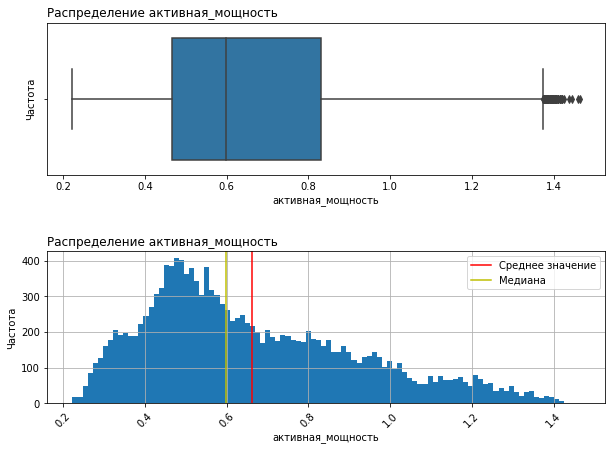

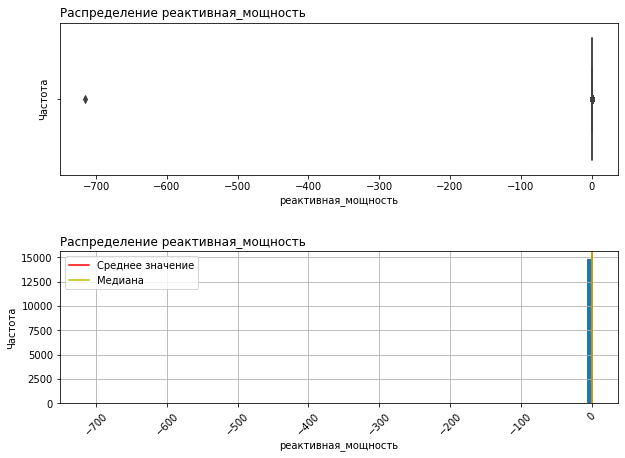

In [36]:
eda(data_arc)

По графикам и описательной статистике видим, что активная мощность распределена практически нормально, распределение имеет более тяжелый правый хвост, значит большинство наблюдений находится в диапазоне 0.22-0.83. В данных же по реактивной мощности присутствует явный выброс (строка со значением минус 715,4799). Можно заменить это значение на медианное и затем построить снова график.

In [37]:
data_arc['реактивная_мощность'].median()

0.44163949999999996

In [38]:
data_arc['реактивная_мощность'] = np.where(
    data_arc['реактивная_мощность'] < 0,
    data_arc['реактивная_мощность'].median(),
    data_arc['реактивная_мощность']
)

------------- Описательная статистика для числовых данных -------------


,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.487112
std,934.571502,0.258885,0.197606
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337192
50%,1617.000000,0.599587,0.441652
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284




------------- Гистограммы для числовых признаков -------------


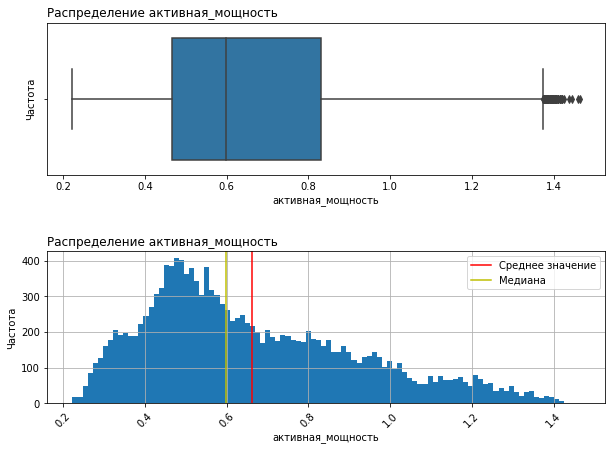

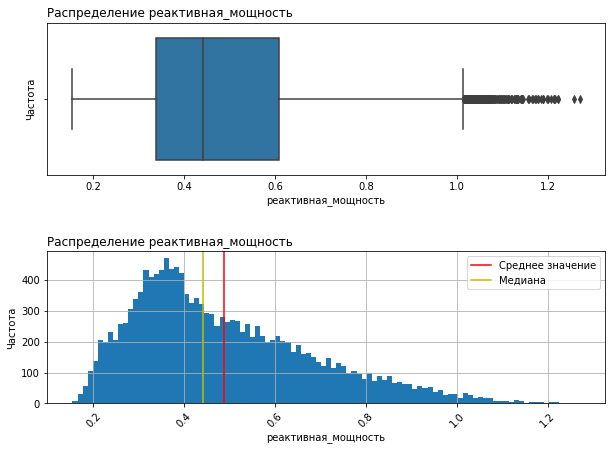

In [39]:
eda(data_arc)

Теперь распределения активной и реактивной мощности похожи. 

**Данные о подаче сыпучих материалов (объём)**

Мы помним, что в данных было очень много пропусков. Чтобы пропуски 'не забивали' графики, в функции предусмотрено dropna().

------------- Описательная статистика для числовых данных -------------


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000




------------- Гистограммы для числовых признаков -------------


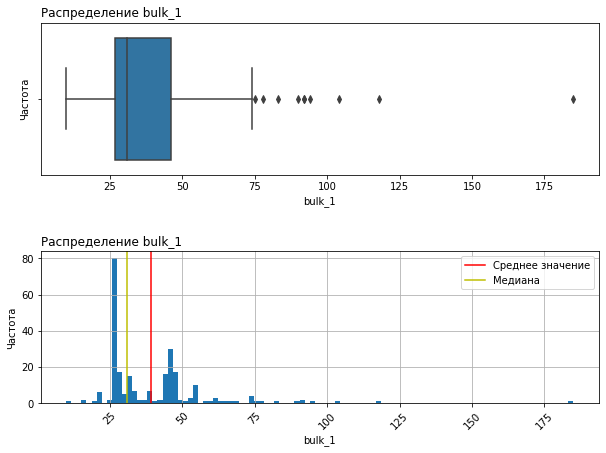

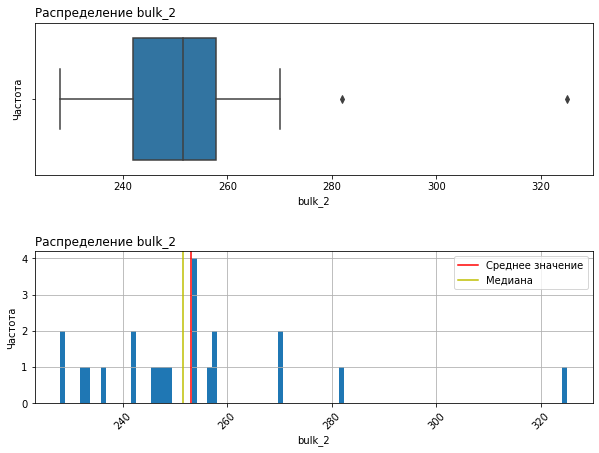

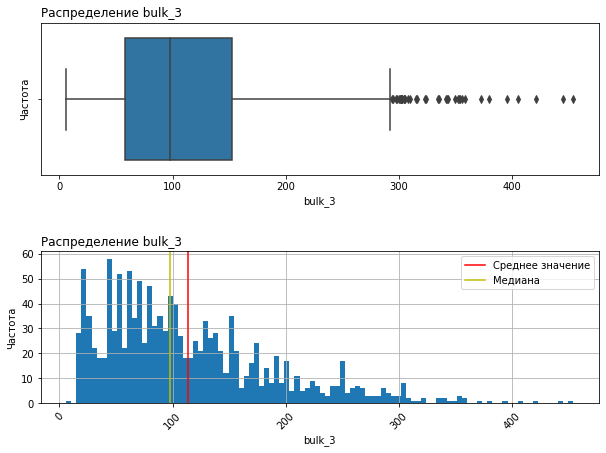

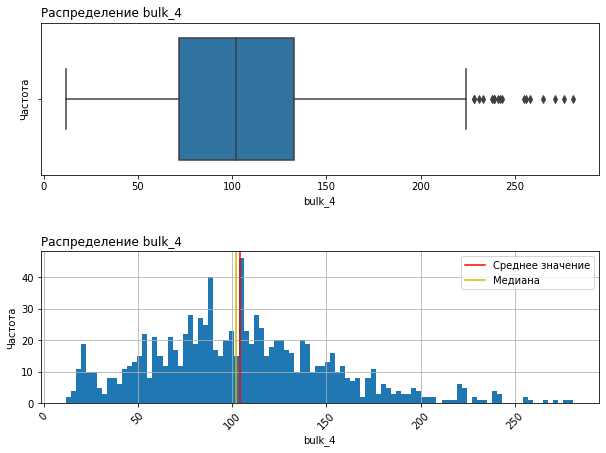

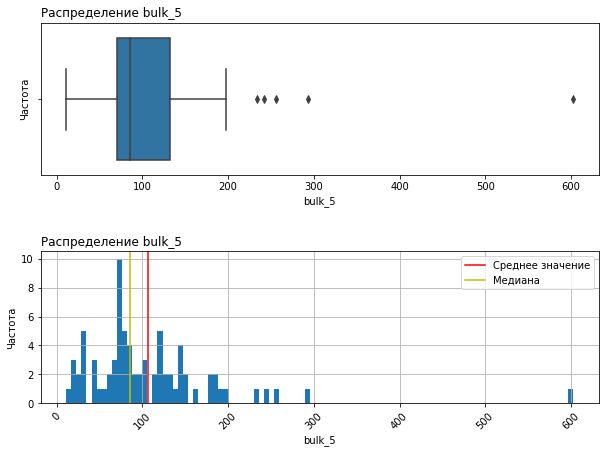

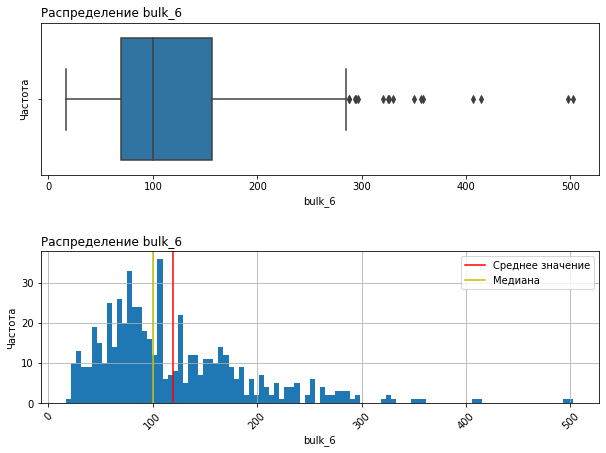

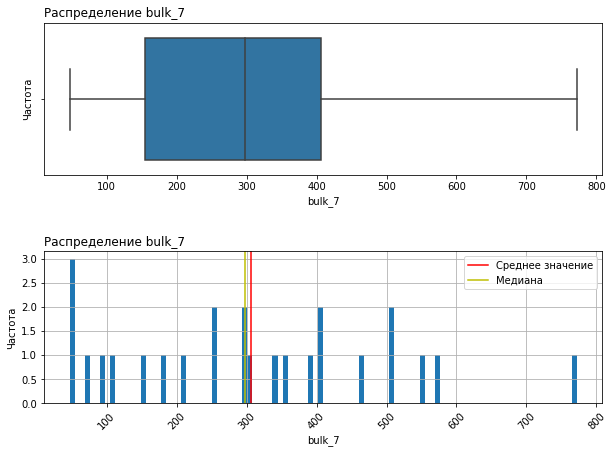

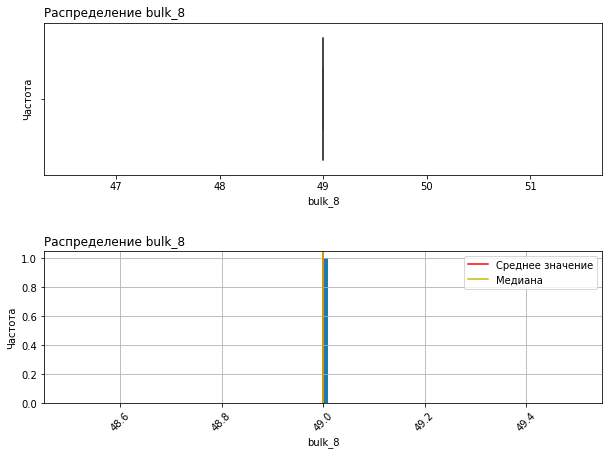

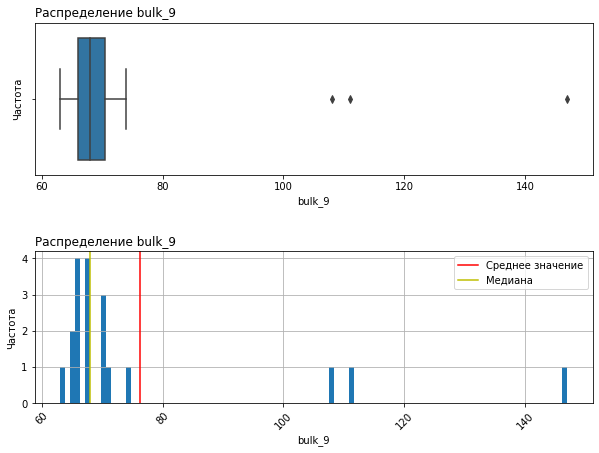

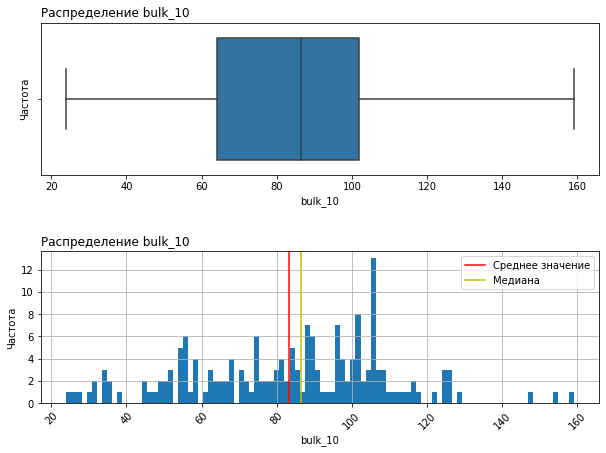

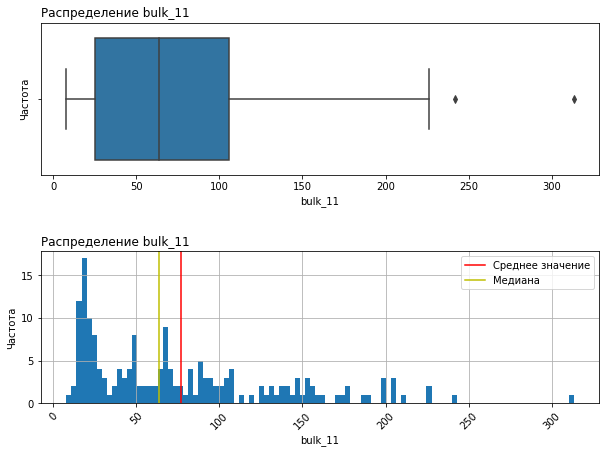

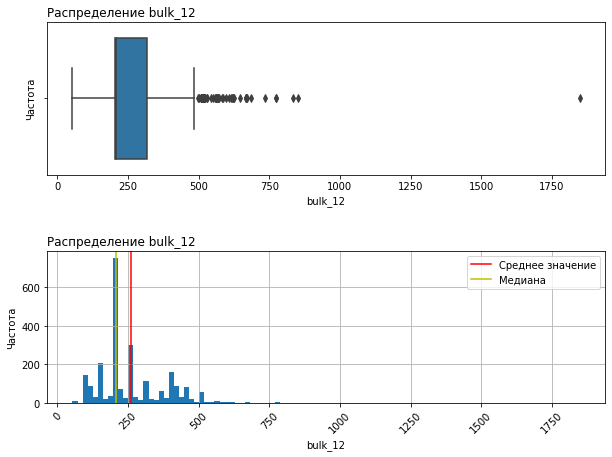

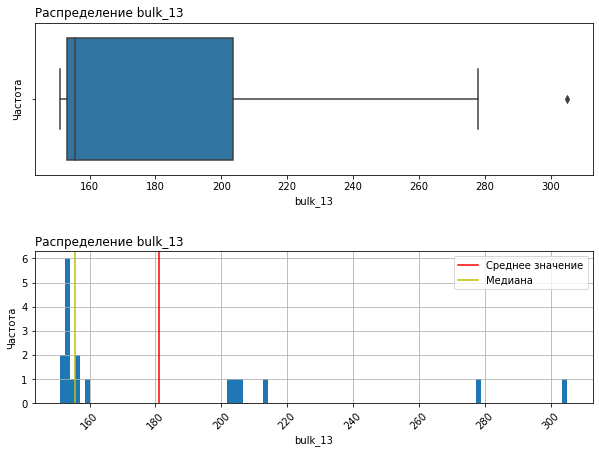

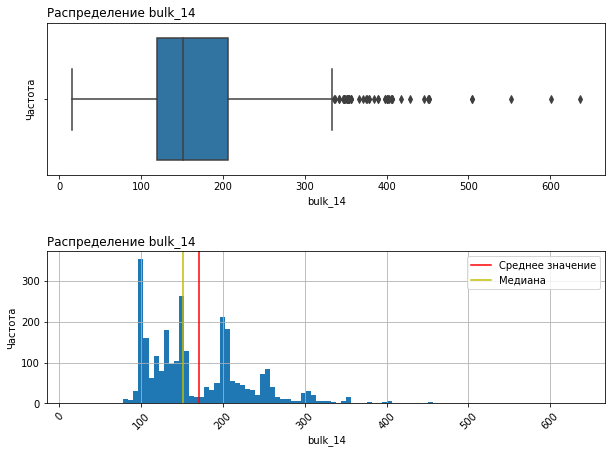

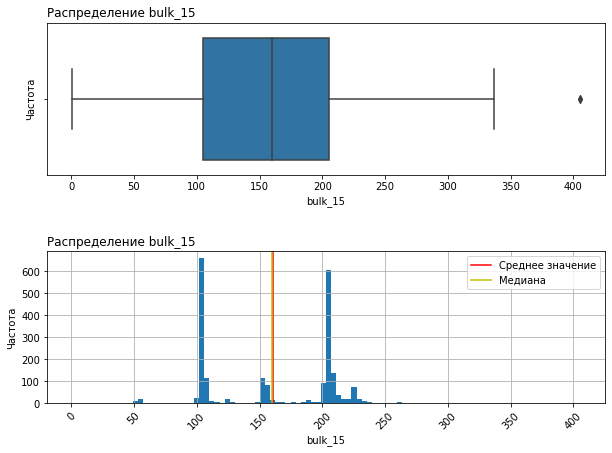

In [40]:
eda(data_bulk_new)

В каждом показателе сыпучих материалов присутствуют выбросы. Например, в bulk_1 видим, что основная масса данных находится в диапозоне 25-50, но есть данные которые превышают межквартильный размах. Такая же примерно картина наблюдается и по всем остальным показателям. Но мы не будем однозначно делать вывод, что это выбросы. Возможно это действительно обусловлено технологией изготовления сплава. Этот момент следует согласовать с заказчиком. Bulk_8 вообще принимает одно единственное значение.

Данные о конкретном времени добавок скорее всего нам не пригодятся. Вряд ли время суток может влиять на состав сплава. Но нам могут понадобиться дельты времени. То же самое можно сказать и по данным по подаче проволочных материалов.

**Данные о продувке сплава газом**

------------- Описательная статистика для числовых данных -------------


,key,газ_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040




------------- Гистограммы для числовых признаков -------------


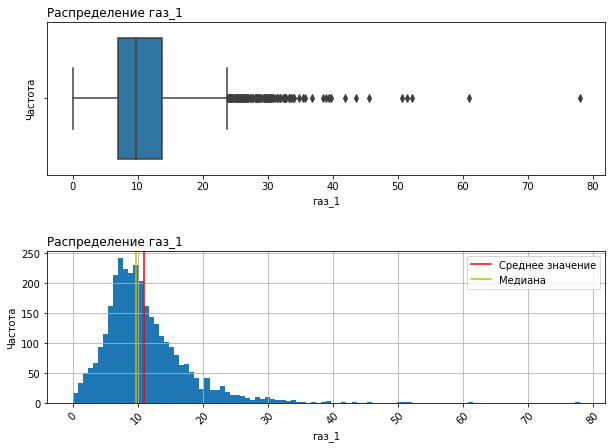

In [41]:
eda(data_gas)

Снова наблюдаем картину множественных выбросов справа. Но однозначно мы не можем сказать, что это аномалии. Этот момент стоит уточнить у заказчика.

**Результаты измерения температуры**

------------- Описательная статистика для числовых данных -------------


,key,температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000




------------- Гистограммы для числовых признаков -------------


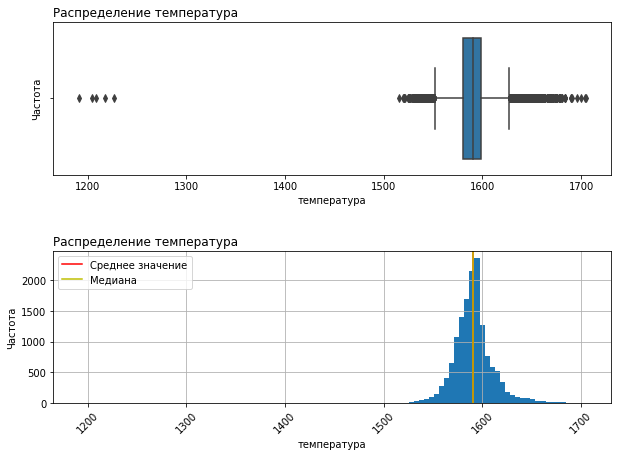

In [42]:
eda(data_temp)

In [43]:
data_temp.head(10)

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


По графику температуры также наблюдаем выбросы, но слева. Температуры ниже 1300 являются аномалиями, поскольку такие величины не предусмотрены технологическим процессом. Удалим такие данные.

In [44]:
data_temp = data_temp[data_temp['температура'] >= 1300]

------------- Описательная статистика для числовых данных -------------


,key,температура
count,14660.000000,14660.000000
mean,1325.369236,1590.852729
std,787.407873,19.143141
min,1.000000,1515.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1962.250000,1599.000000
max,3241.000000,1705.000000




------------- Гистограммы для числовых признаков -------------


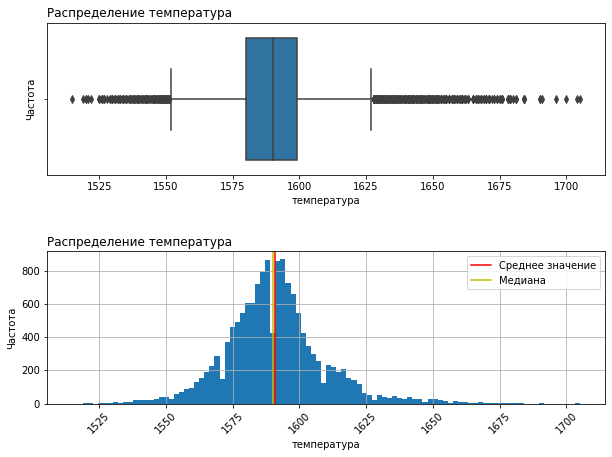

In [45]:
eda(data_temp)

Теперь данные распределены нормально.

**Данные о проволочных материалах**

Как и в данных по сыпучим материалах, в данных о проволочных материалах было много пропусков. В функции eda для построения графиков предусмотрено dropna(), чтобы не искажать графики.


------------- Описательная статистика для числовых данных -------------


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604




------------- Гистограммы для числовых признаков -------------


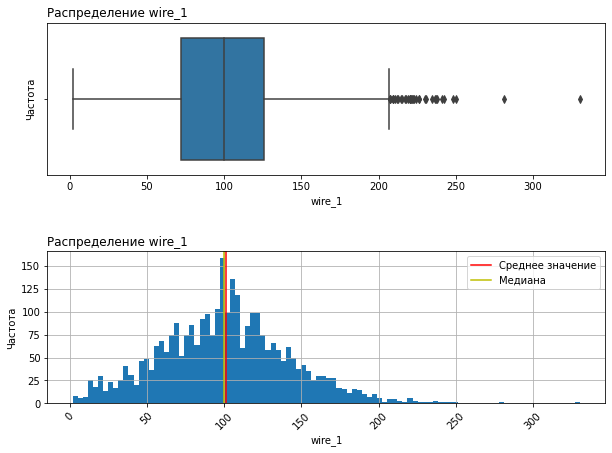

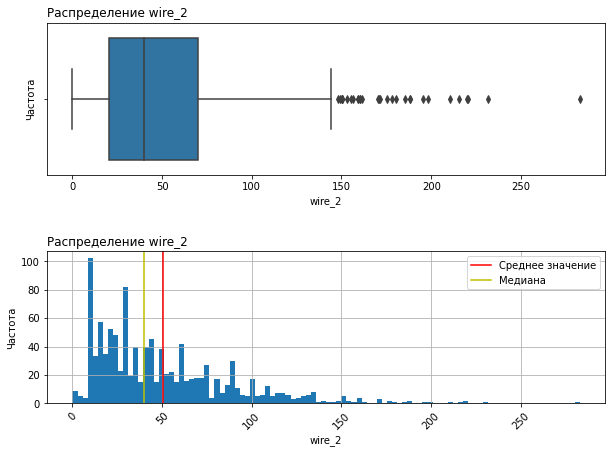

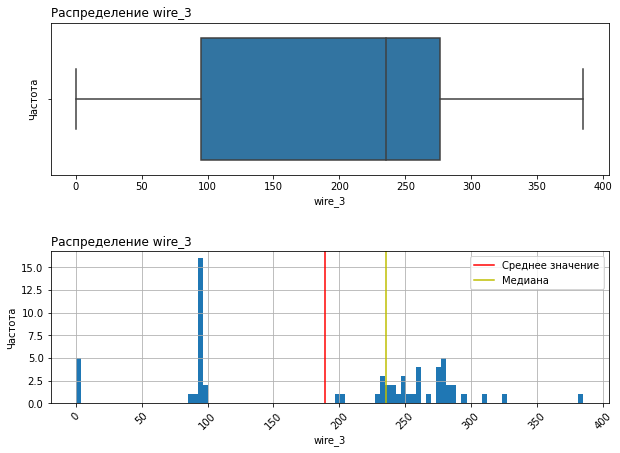

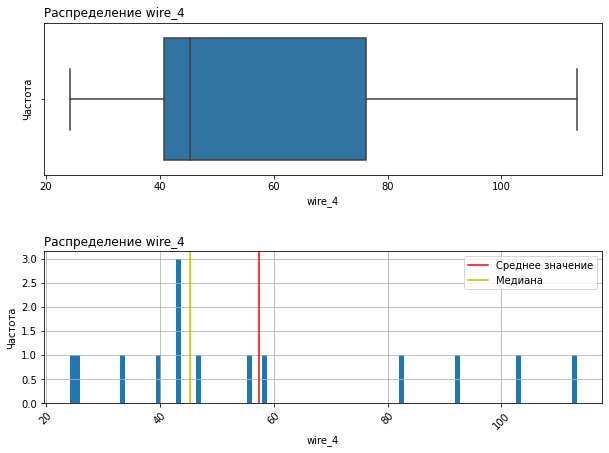

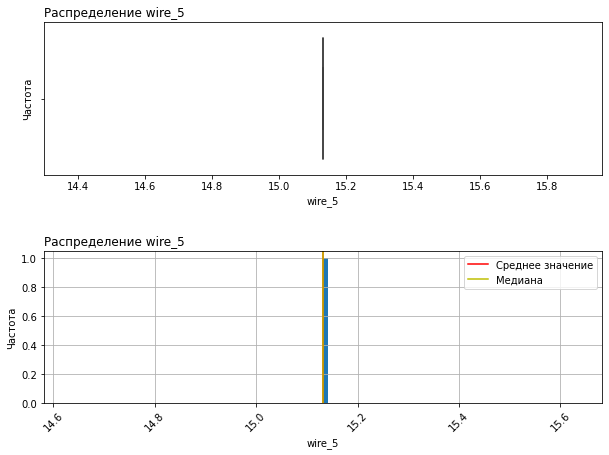

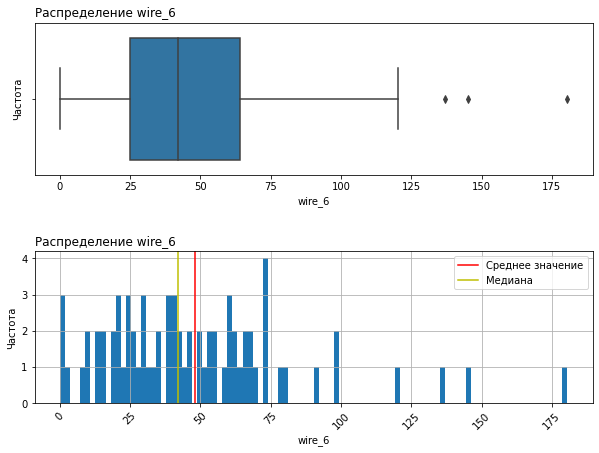

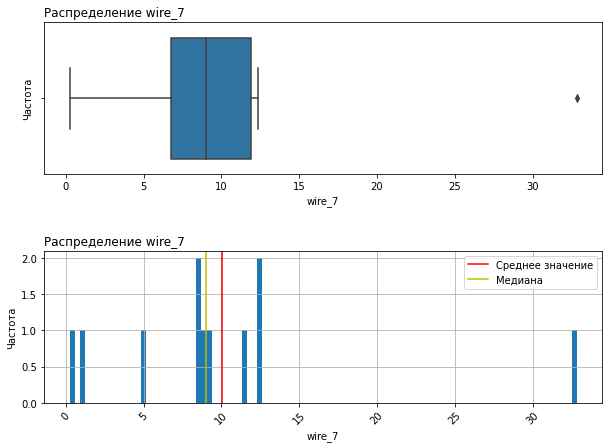

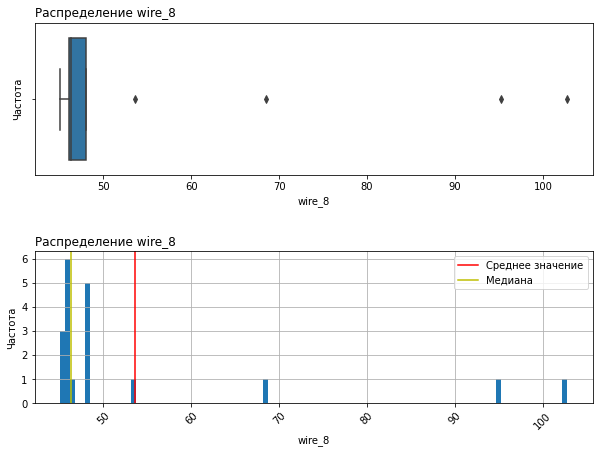

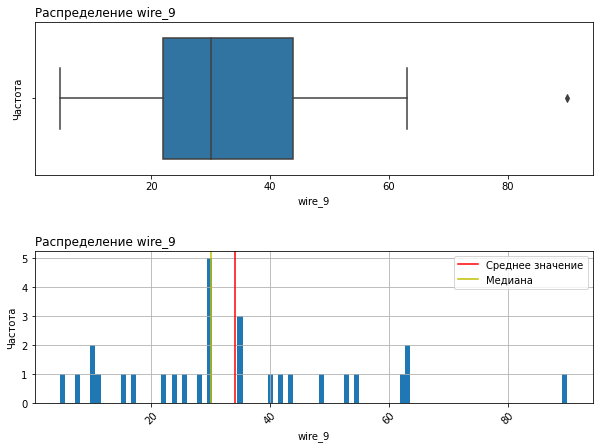

In [46]:
eda(data_wire)

Как и в данных для сыпучих материалов наблюдаем везде выбросы, о которых мы не можем точно судить, как об аномалиях. Этот момент следует уточнить у заказчика.

**Промежуточный вывод по разделу предобработка данных**

Изучили описательную статистику для каждого датафрейма за исключением данных о времени. Заменили явный выброс в данных по реактивной мощности (большое отрицательное значение) на медианное значение. Все данные содержат выбросы, которые мы пока никак не обрабатывали, поскольку возможно эти значения являются элементами технологии, а не аномалиями. Следует заметить, что все выбросы, за исключением температуры (эти аномалии были удалены из датасета) нагрева размещены справа. Можно предположить, что возможно есть какие-то специальные сплавы, где по технологии и больше подача добавок и больше порция продувки газом. Также возможно, это нарушение технологии. Этот момент необходимо донести до заказчика и согласовать. Если это действительно какая-то отдельная группа сплавов, то вероятно будет разумно выделить ее в отдельную кагорту и провести отдельный анализ и обучение своей индивидуальной модели. 

<a id='section_id2'></a>
### Объединение данных.

Перед объединением данных поработаем с каждой таблицей и примем решение какие данные будут нам полезны для построения модели,  а какие и вовсе не понадобятся.

**Данные об электродах**

Введем дополнительные переменные
- расчет времени в секундах S
- полная мощность W = (Active^2+Reactive^2)^0.5
- полную энергию E = W * S

In [47]:
data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [48]:
data_arc['полная_мощность'] = (data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)**0.5
data_arc['время_нагрева'] = (data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']).dt.seconds
data_arc['полная_энергия'] = data_arc['полная_мощность'] * data_arc['время_нагрева']
data_arc.head(5)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,полная_мощность,время_нагрева,полная_энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,159.830252


Создадим сводную таблицу, чтобы для каждой партии металла посчитать суммарные значения мощностей и общее время нагрева, а также количество итераций процесса нагрева. Мы проводим такую агрегацию, поскольку заказчика интересует именно конечная температура сплава.

In [49]:
data_arc.columns

Index(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность', 'полная_мощность',
       'время_нагрева', 'полная_энергия'],
      dtype='object')

In [50]:
data_arc = data_arc.pivot_table(index='key',
                    values=['активная_мощность', 'реактивная_мощность', 'полная_мощность',
       'время_нагрева', 'полная_энергия', 'начало_нагрева_дугой'],
                    aggfunc=
                    {'активная_мощность': 'sum', 
                     'реактивная_мощность': 'sum', 
                     'полная_мощность': 'sum',
                     'время_нагрева': 'sum', 
                     'полная_энергия': 'sum',
                     'начало_нагрева_дугой': 'count'}).reset_index()

In [51]:
data_arc.columns

Index(['key', 'активная_мощность', 'время_нагрева', 'начало_нагрева_дугой',
       'полная_мощность', 'полная_энергия', 'реактивная_мощность'],
      dtype='object')

In [52]:
data_arc.columns = ['key', 'активная_мощность', 'время_нагрева', 'количество_циклов',
       'полная_мощность', 'полная_энергия', 'реактивная_мощность']

In [53]:
data_arc.head()

,key,активная_мощность,время_нагрева,количество_циклов,полная_мощность,полная_энергия,реактивная_мощность
0,1,3.036730,1098,5,3.718736,770.282114,2.142821
1,2,2.139408,811,4,2.588349,481.760005,1.453357
2,3,4.063641,655,5,5.019223,722.837668,2.937457
3,4,2.706489,741,4,3.400038,683.455597,2.056992
4,5,2.252950,869,4,2.816980,512.169934,1.687991


Для красоты изменим порядок столбцов.

In [54]:
data_arc = data_arc[['key', 'время_нагрева', 'активная_мощность', 'реактивная_мощность', 'полная_мощность', 
                     'полная_энергия', 'количество_циклов' ]]

In [55]:
data_arc.head()

,key,время_нагрева,активная_мощность,реактивная_мощность,полная_мощность,полная_энергия,количество_циклов
0,1,1098,3.036730,2.142821,3.718736,770.282114,5
1,2,811,2.139408,1.453357,2.588349,481.760005,4
2,3,655,4.063641,2.937457,5.019223,722.837668,5
3,4,741,2.706489,2.056992,3.400038,683.455597,4
4,5,869,2.252950,1.687991,2.816980,512.169934,4


**Данные о температуре**

Выведем снова первые пять строк данных о температуре.

In [56]:
data_temp.head()

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


По первым пяти строкам видим, что для каждой партии сплава присутствуют замеры в определенные промежутки времени. Нас интересует только начальная температура и конечная, которая будет являться целевой переменной.

Отбросим пропуски в данных.

In [57]:
data_temp = data_temp.dropna()

Произведем агрегацию данных по номеру партии и посмотрим по каким партиям было всего одно измерение температуты. Такие данные мы откинем, поскольку нас интересует два показателя (температура начала нагрева и конечная температура).

In [58]:
data_temp.groupby('key').count().sort_values(by='key', ascending=False)

,время_замера,температура
key,,
3241,1,1
3240,1,1
3239,1,1
3238,1,1
3237,1,1
...,...,...
5,5,5
4,5,5
3,6,6


Видим, что такие данные присутствуют. Создадим список таких партий для фильтрации данных.

In [59]:
bad_key = data_temp.groupby('key').count().reset_index()
bad_key = bad_key[bad_key['время_замера']==1]['key'].tolist()

In [60]:
data_temp = data_temp.query('key not in @bad_key')

И наконец создадим сводную таблицу по номеру партии с первым и последним значением температуры. Обязательно отсортируем данные по времени.

In [61]:
data_temp = data_temp.sort_values(by='время_замера').pivot_table(index='key', values='температура', 
                                                    aggfunc=['first', 'last']).reset_index()
                                                    

In [62]:
data_temp.columns = ['key', 'начальная_температура', 'конечная_температура']
data_temp.head()

,key,начальная_температура,конечная_температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Далее объединим все данные в единый датафрейм, в которые мы не будем включать данные о времени подачи сыпучих материалов и проволочных добавок поскольку в данном случае мы не имеем дело с временным рядом и время суток никак не влияет на качество сплава. Перед объединением проверим размер датафрейма, а именно количество строк с целевой переменной, чтобы далее сравнить с количеством строк в итоговом датафрейме для контроля корректности объединения. В итоговом датафрейме не должно получиться строк больше, чем в таблице с темепературой.

In [63]:
data_temp.shape

(2475, 3)

Всего имеем 2475 наблюдений.

Объединим датафреймы по ключу key

In [64]:
data_final = data_arc.merge(data_bulk_new, on='key', how='inner').merge(data_gas, on='key', how='inner').\
merge(data_wire, on='key', how='inner').merge(data_temp, on='key', how='inner')
data_final.head()

,key,время_нагрева,активная_мощность,реактивная_мощность,полная_мощность,полная_энергия,количество_циклов,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,газ_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,начальная_температура,конечная_температура
0,1,1098,3.036730,2.142821,3.718736,770.282114,5,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1571.0,1613.0
1,2,811,2.139408,1.453357,2.588349,481.760005,4,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1581.0,1602.0
2,3,655,4.063641,2.937457,5.019223,722.837668,5,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1596.0,1599.0
3,4,741,2.706489,2.056992,3.400038,683.455597,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1601.0,1625.0
4,5,869,2.252950,1.687991,2.816980,512.169934,4,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1576.0,1602.0


Проверим размер итоговой таблицы.

In [65]:
data_final.shape

(2329, 34)

Поскольку мы выполнили объединение inner и итоговый размер таблицы меньше по количеству строк, то можем сделать вывод, что какие-то номера партий отсутствовали либо в одном, либо в другом датасете. 

**Промежуточный вывод**


Сдедали преобразования таблиц, добавили новые признаки, провели агрегацию, посчитали количество циклов нагрева, нашли начальную и конечную температуры нагрева, приняли решение какие данные не будем использовать для обучения моделей. Произвели объединение необходимых датасетов по ключу key методом inner, проконтролировали размер датасетов.

<a id='section_id2'></a>
### Корреляционный анализ и исследовательский анализ данных единого датасета.

Не смотря на то, что ранее мы выводили описательную статистику и графики распределения признаков и целевой переменной, выполним это исследование снова, так как после объединения таблиц мы потеряли некоторую часть данных, а также у нас появились новые признаки.

Проверим количество пропусков в относительном соотношении.

In [66]:
data_final.isna().sum()/len(data_final)

key                      0.000000
время_нагрева            0.000000
активная_мощность        0.000000
реактивная_мощность      0.000000
полная_мощность          0.000000
полная_энергия           0.000000
количество_циклов        0.000000
bulk_1                   0.914556
bulk_2                   0.994418
bulk_3                   0.587806
bulk_4                   0.651353
bulk_5                   0.977243
bulk_6                   0.811936
bulk_7                   0.994418
bulk_8                   0.999571
bulk_9                   0.994418
bulk_10                  0.938600
bulk_11                  0.944182
bulk_12                  0.221984
bulk_13                  0.993989
bulk_14                  0.112065
bulk_15                  0.270502
газ_1                    0.000000
wire_1                   0.009875
wire_2                   0.651782
wire_3                   0.983255
wire_4                   0.994848
wire_5                   1.000000
wire_6                   0.980678
wire_7        

Видим, что некоторые признаки практически или полностью не заполнены. Отбросим те данные, где пропусков больше 90%. 

In [67]:
data_final.drop(columns=['bulk_1', 'bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
                         'bulk_13', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], inplace=True)

Оставшиеся пропуски заполним нулями.

In [68]:
data_final = data_final.fillna(0)

In [69]:
data_final.isna().sum()/len(data_final)

key                      0.0
время_нагрева            0.0
активная_мощность        0.0
реактивная_мощность      0.0
полная_мощность          0.0
полная_энергия           0.0
количество_циклов        0.0
bulk_3                   0.0
bulk_4                   0.0
bulk_6                   0.0
bulk_12                  0.0
bulk_14                  0.0
bulk_15                  0.0
газ_1                    0.0
wire_1                   0.0
wire_2                   0.0
начальная_температура    0.0
конечная_температура     0.0
dtype: float64

------------- Описательная статистика для числовых данных -------------


,key,время_нагрева,активная_мощность,реактивная_мощность,полная_мощность,полная_энергия,количество_циклов,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,газ_1,wire_1,wire_2,начальная_температура,конечная_температура
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,807.647488,3.125336,2.300712,3.885011,669.780462,4.695578,47.348218,37.303564,22.430228,208.415629,153.853585,119.952769,11.375600,102.443601,17.609859,1587.386003,1593.365393
std,714.762400,340.838388,1.220799,0.903850,1.517919,319.488817,1.606629,75.310430,58.643238,55.790873,157.062272,81.404354,84.640443,6.392041,43.539993,33.624771,23.619841,11.200915
min,1.000000,57.000000,0.267676,0.196228,0.331897,33.430208,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,1519.000000,1541.000000
25%,630.000000,581.000000,2.295820,1.670519,2.844193,457.864703,4.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,7.282948,73.207679,0.000000,1571.000000,1587.000000
50%,1255.000000,778.000000,3.035365,2.225398,3.767499,630.714148,5.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,10.100950,101.119201,0.000000,1587.000000,1593.000000
75%,1868.000000,993.000000,3.834300,2.829159,4.769421,841.398018,6.000000,80.000000,77.000000,0.000000,282.000000,204.000000,204.000000,14.216688,128.091599,23.102560,1603.000000,1598.000000
max,2499.000000,4189.000000,12.375636,8.949049,15.288271,4546.405812,16.000000,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,77.995040,330.314424,282.780152,1660.000000,1653.000000




------------- Гистограммы для числовых признаков -------------


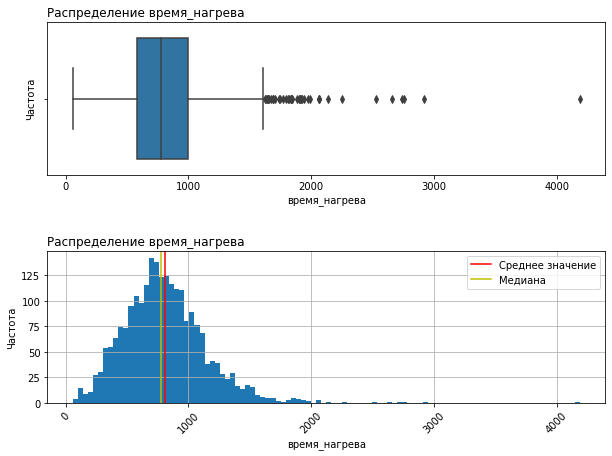

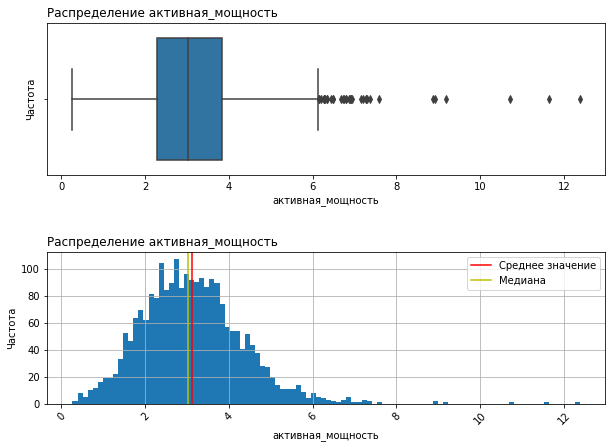

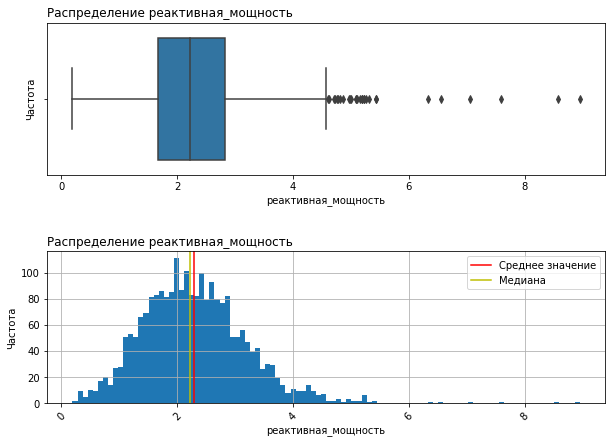

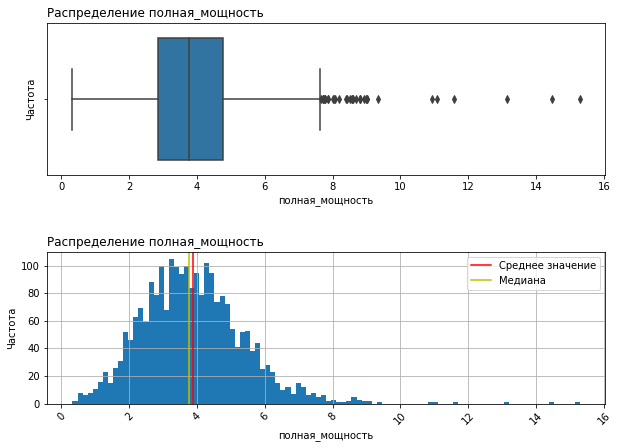

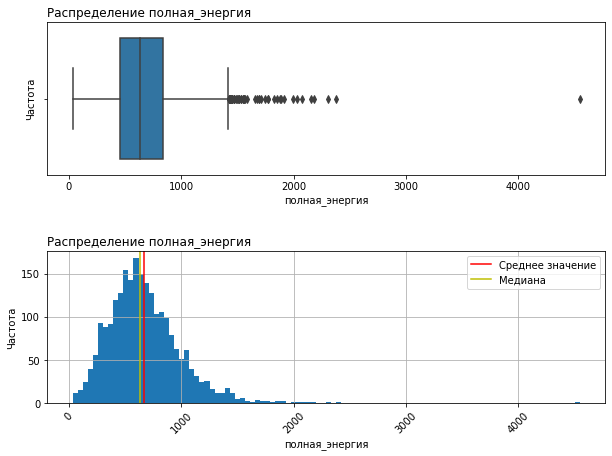

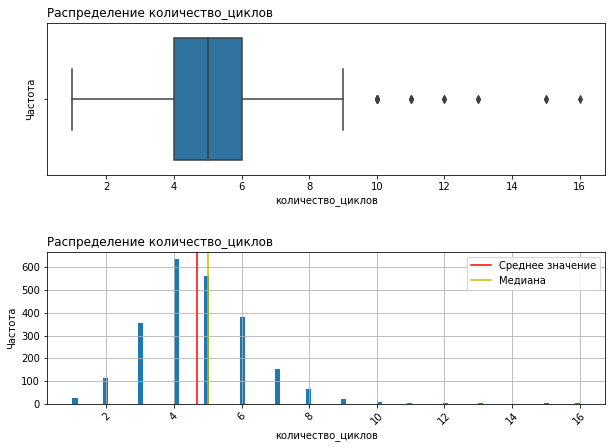

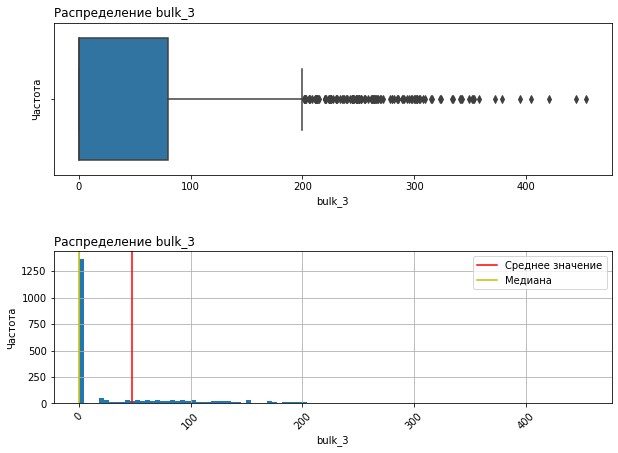

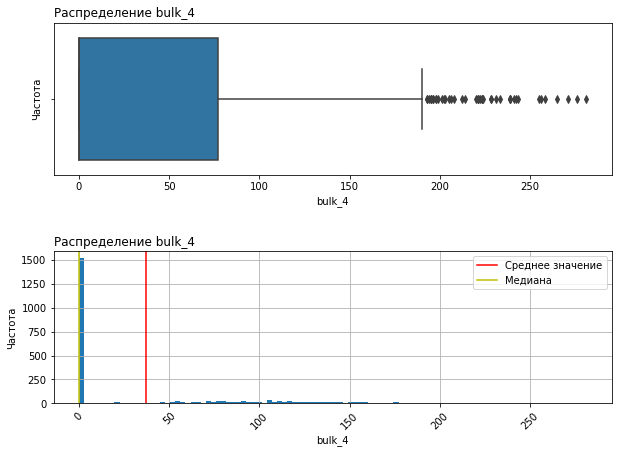

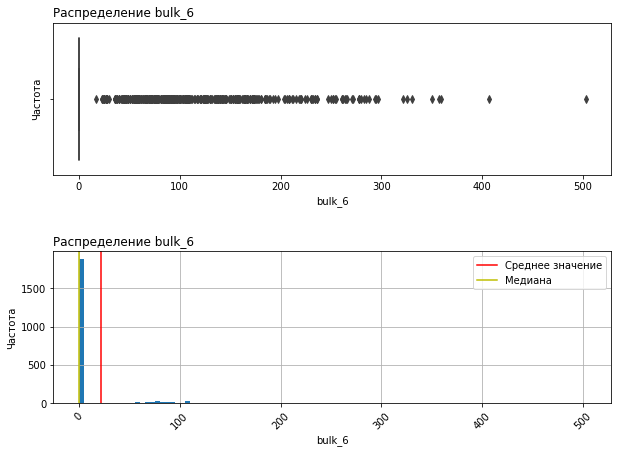

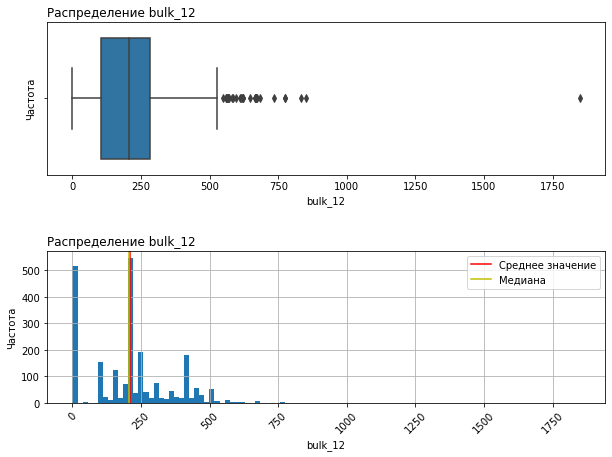

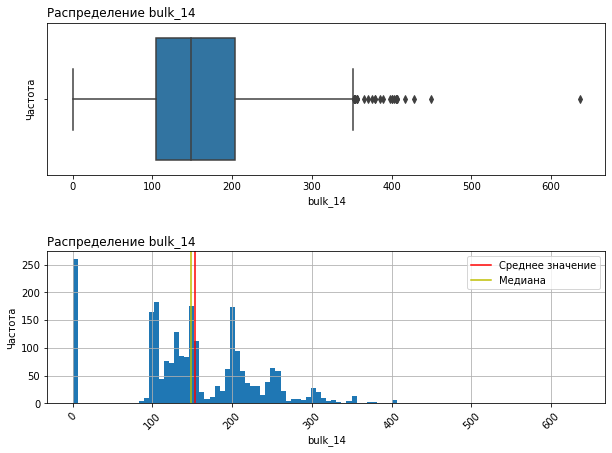

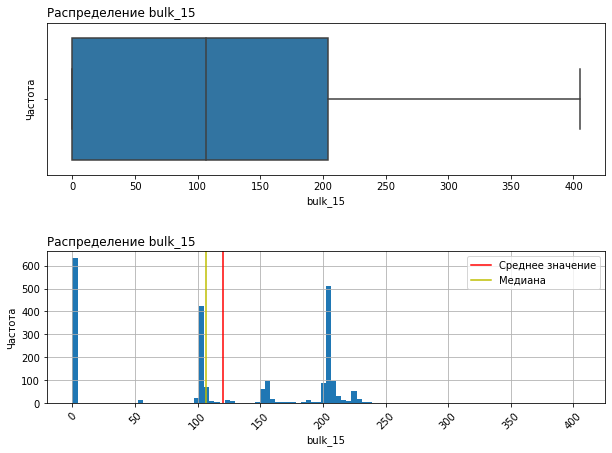

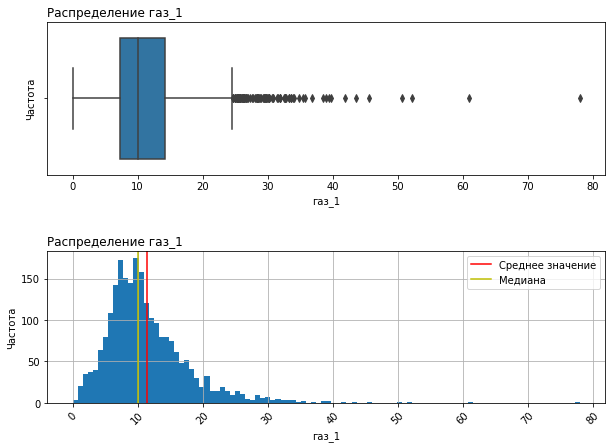

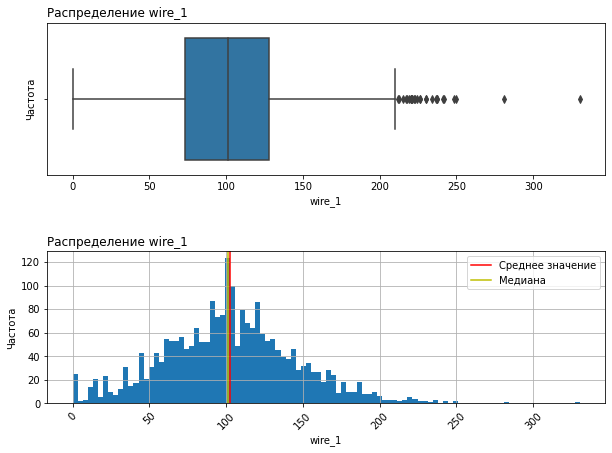

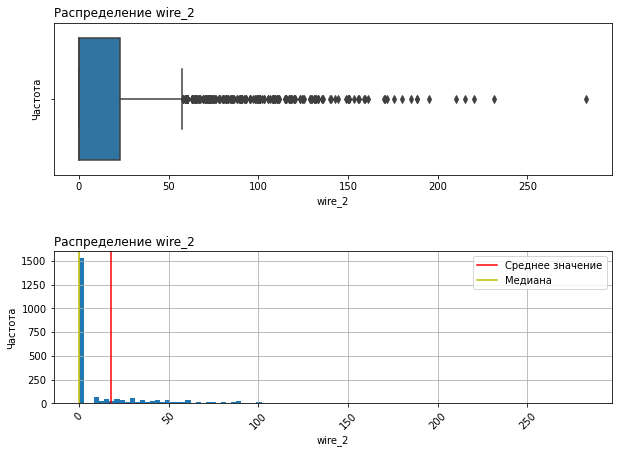

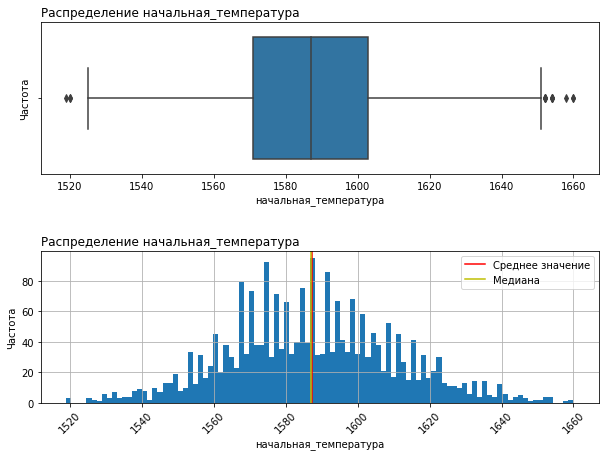

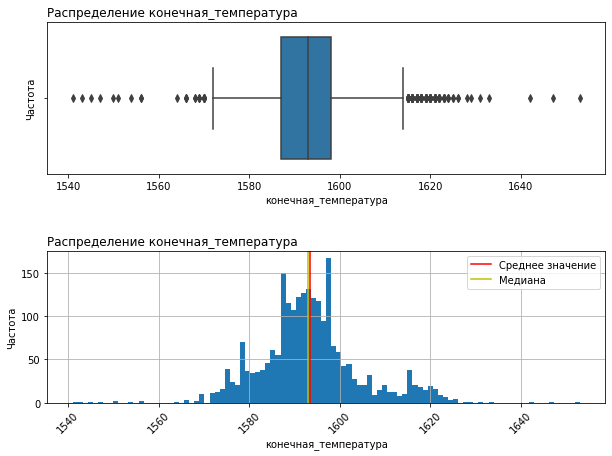

In [70]:
eda(data_final)

Видим, что во всех данных есть статистические выбросы. 
Что больше всего бросается в глаза:
- общее время нагрева, активная мощность, реактивная мощность, полная мощность, полная энергия, добавки других компонентов, количество итераций нагрева - везде выбросы справа. Так как данные зависят друг от друга (при увеличении времени нагрева, мощность и энергия также увеличиваются), то это не кажется аномалией, а скорее просто статистическим выбросом. Но также это может сигнализировать о каких-то нарушениях либо об особенностях технологического процесса, о чем мы упоминалее выше (возможно стоит выделить отдельную группу сплавов, где подача добавок и продувка газом повышена)
- начальная температура имеет выбросы и слева, и справа, но распределена нормально. Возможно и здесь идет речь о нарушении технологического процесса.
- конечная температура распределена практически нормально, но также имеются статистические выбросы и слева, и справа. Также обратим внимание, что стандартное отклонение равно 11, т.е. разброс данных не велик.

Для того, чтобы принять решение удалять ли выбросы, этот момент следует обсудить со специалистом заказчика, чтобы точно понимать в о чем идет речь - об ошибках в данных или же о нарушениях технологии, либо об особенностях производства. Поскольку мы хотим имитировать реальную работу предприятия, то на данном этапе принимаем решение выбросы не обрабатывать и обучить на таких данных модель. В качестве метрики оценки качества работы модели мы выбрали MAE, а она менее чувствительна к выбросам нежели MSE. Так что у нас есть шанс обучить хорошую модель. Но тем не менее мы сравним ее работу с DummyRegressor и проверим метрику R2, поскольку как мы указали выше, стандартное отклонение не так и велико. Основная масса данных о конечной температуре распределена вокруг среднее значения, что мы также помним из графика распределения.

Построим графики рассеяния для анализа зависимости целевой переменной от других численных признаков.

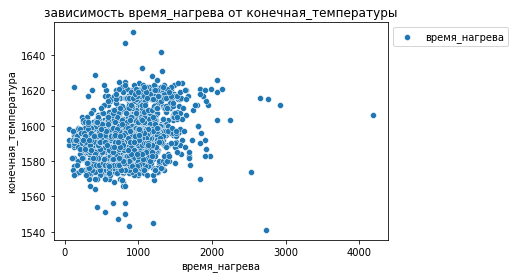

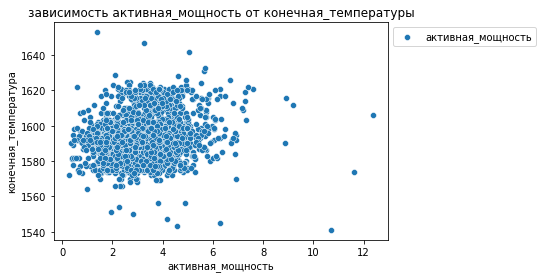

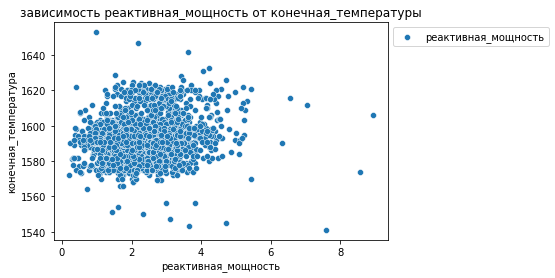

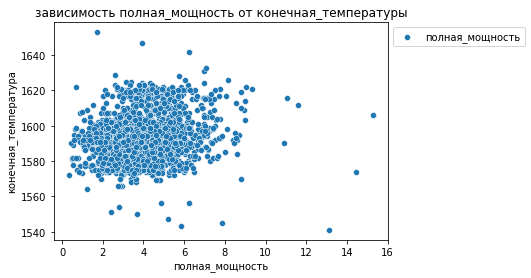

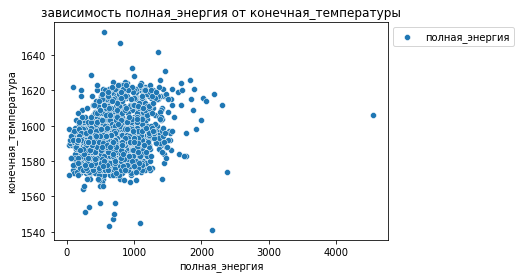

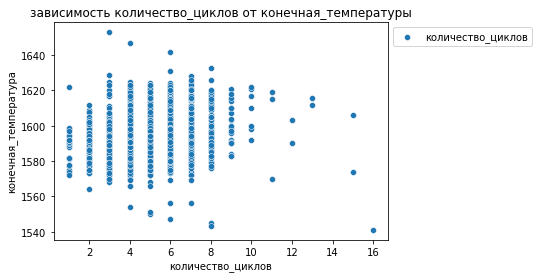

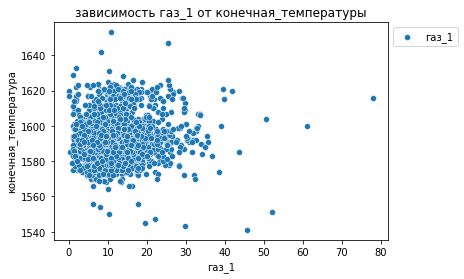

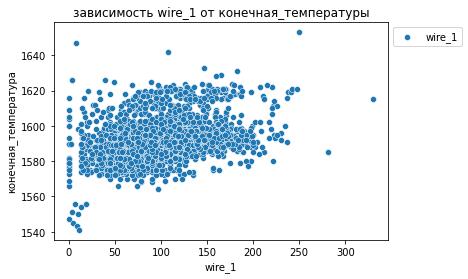

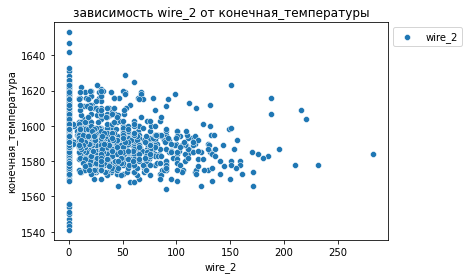

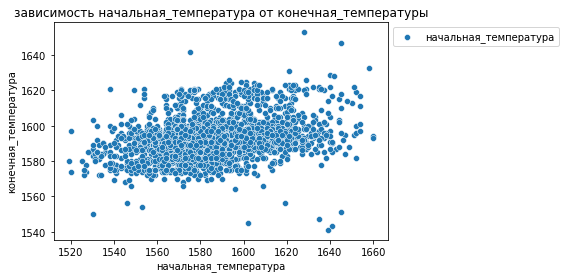

In [71]:
for i in ['время_нагрева', 'активная_мощность', 'реактивная_мощность',
       'полная_мощность', 'полная_энергия', 'количество_циклов', 'газ_1', 'wire_1',
       'wire_2', 'начальная_температура']:
    sns.scatterplot(data=data_final, x=i, y='конечная_температура', label=i)
    plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
    plt.title(f'зависимость {i} от конечная_температуры')
    plt.xlabel(f'{i}')
    plt.ylabel('конечная_температура')           
    plt.show()

По графикам видим, что как таковых линейных зависимостей нет. 

Проведем корреляционный анализ.

In [72]:
data_final.columns

Index(['key', 'время_нагрева', 'активная_мощность', 'реактивная_мощность',
       'полная_мощность', 'полная_энергия', 'количество_циклов', 'bulk_3',
       'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'газ_1', 'wire_1',
       'wire_2', 'начальная_температура', 'конечная_температура'],
      dtype='object')

In [73]:
# phik корреляция
interval_cols = ['время_нагрева', 'активная_мощность', 'реактивная_мощность',
       'полная_мощность', 'полная_энергия', 'количество_циклов', 'bulk_3',
       'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'газ_1', 'wire_1',
       'wire_2', 'начальная_температура', 'конечная_температура']

In [74]:
phik_overview = data_final.phik_matrix(interval_cols=interval_cols)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable key is large: 2329. Are you sure this is not an interval variable? Analysis for pairs of variables including key can be slow.
  warnings.warn(


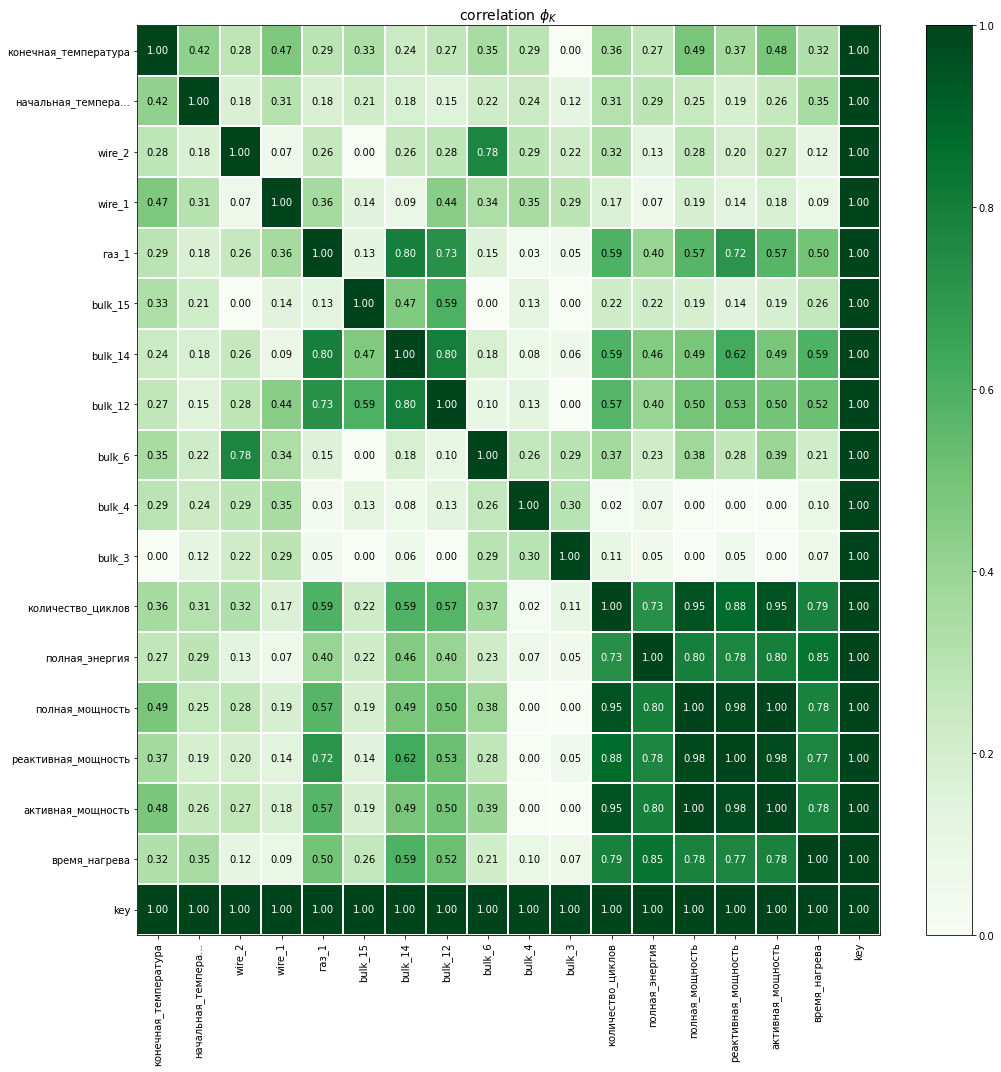

In [75]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 15))

Для начала посмотрим на корреляцию целевой переменной конечная температура с остальными признаками. 
Мы видим, что конечная температура значительно зависит от:
- полной мощности
- активной мощности
- добавки wire_1

При этом совсем не зависит от:
- bulk_3

Мультиколлинеарность не наблюдается за исключением признаков, которые мы ввели дополнительно. Но поскольку мы их вводили по принципу добавления полиноминальных признаков, то эти данные по идее должны улучшить работу модели. Но если модель покажет плохие результаты или нестабильную работу, то мы удалим какие-то из этих признаков.


Удалим признак bulk_3

In [76]:
data_final.drop('bulk_3', axis=1, inplace=True)

In [77]:
data_final.head()

,key,время_нагрева,активная_мощность,реактивная_мощность,полная_мощность,полная_энергия,количество_циклов,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,газ_1,wire_1,wire_2,начальная_температура,конечная_температура
0,1,1098,3.036730,2.142821,3.718736,770.282114,5,43.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000,1571.0,1613.0
1,2,811,2.139408,1.453357,2.588349,481.760005,4,73.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000,1581.0,1602.0
2,3,655,4.063641,2.937457,5.019223,722.837668,5,34.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000,1596.0,1599.0
3,4,741,2.706489,2.056992,3.400038,683.455597,4,81.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000,1601.0,1625.0
4,5,869,2.252950,1.687991,2.816980,512.169934,4,78.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456,1576.0,1602.0


**Промежуточный вывод**

Провели исследовательский анализ финального датасета, посмотрели описательную статистику, корреляцию. 
По итогам исследования избавились от признаков с большим количеством пропусков и тех, которые не имеют зависимости от целевой переменной. Пропуски заполнили нулями. Обратили внимание на сдвиг всех распределений вправо и предположили, что существует отдельная категория сплавов с увеличинными подачами добавок и продувки газом.

<a id='section_id5'></a>
### Подготовка данных для обучения.

Разобьем тренировочную выборку на входные признаки и целевую переменную.

In [78]:
X = data_final.drop(['key','конечная_температура'], axis=1)

In [79]:
y = data_final['конечная_температура']

Введем новую переменную RANDOM_STATE.

In [80]:
RANDOM_STATE = 250825

Разобьем данные на тренировочную и тестовые выборки.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Создадим пайплайны для обработки данных, затем объединим их в препроцессор, который в свою очередь включим в итоговый пайплайн.

In [82]:
num_columns = X.columns.tolist()

In [83]:
# Создаем пайплайн для подготовки данных к обучению.
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


In [84]:
# Cоздаём итоговый пайплайн: подготовка данных и модель.
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

**Промежуточный вывод**


Подготовили входящие признаки и целевую переменную, сделали разбивку на тренировочные и тестовые данные. Подготовили data preprocessor и итоговый пайп. 

<a id='section_id6'></a>
### Обучение моделей.

Обучим несколько моделей. Возьмем одну линейную модель, дерево решений и LGBMRegressor. Подберем гиперпараметры.
Выберем лучшую модель и проверим её качество. Выбор будет делаться на основе метрики — МАЕ. 

Можно было бы сделать единый пайплайн для всех моделей. Но мы создадим три объекта поиска по сетке, чтобы создать сводную таблицу для заказчика по каждой отдельной модели.

Создаем списки параметров для поиска по сетке для разных моделей.

In [85]:
param_grid_tree = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
       'models__criterion': ['squared_error', 'absolute_error'],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
        
    }]

In [86]:
param_grid_elastic = [
    # словарь для модели ElasticNet()
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__l1_ratio': [.1, .5, .7,.9, .95, .99, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }]

In [87]:
param_grid_LGBM = [
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)],
        'models__max_depth': [2, 5, 8, 10, 12],
        'models__num_leaves': [2, 3, 5, 7, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }]

Создадим два пустых списка для того, чтобы далее их объединить в единый датафрейм.

In [88]:
model = []
mae_cross_val_score = []

Создадим объекты поиска по сетке для трех моделей.

**Дерево решений**

In [89]:
model.append('DecisionTreeRegressor')

In [90]:
randomized_search_tree = RandomizedSearchCV(
    pipe_final, 
    param_grid_tree, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Обучим модель.

In [91]:
randomized_search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['время_нагрева',
                                                                                'активная_мощность',
                                                                                'реактивная_мощность',
                                                                                'полная_мощность',
                                                                                'полная_энергия',
                                                                                'количество_циклов',
                                                                                'bulk_4',
                                                                                'bulk_6',
                                                                                'bulk_12',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'газ_1',
                                                                                'wire_1',
                                                                                'wire_2',
                                                                                'начальная_темпера...
                                             ('models',
                                              DecisionTreeRegressor(random_state=250825))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=250825)],
                                         'models__criterion': ['squared_error',
                                                               'absolute_error'],
                                         'models__max_depth': range(2, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=250825, scoring='neg_mean_absolute_error')

In [92]:
print('Лучшая модель и её параметры:\n\n', randomized_search_tree.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['время_нагрева',
                                                   'активная_мощность',
                                                   'реактивная_мощность',
                                                   'полная_мощность',
                                                   'полная_энергия',
                                                   'количество_циклов',
                                                   'bulk_4', 'bulk_6',
                                                   'bulk_12', 'bulk_14',
                                                   'bulk_15', 'газ_1', 'wire_1',
                                                   'wire_2',
                                                   'начальная_температура'])])),
        

In [93]:
print ('Результат метрики на кросс-валидации:', -randomized_search_tree.best_score_)

Результат метрики на кросс-валидации: 7.244908718788375


In [94]:
mae_cross_val_score.append(round(-randomized_search_tree.best_score_,2))

In [95]:
mae_cross_val_score

[7.24]

**ElasticNet**

In [97]:
model.append('ElasticNet')

In [98]:
randomized_search_elastic = RandomizedSearchCV(
    pipe_final, 
    param_grid_elastic, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [99]:
randomized_search_elastic.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['время_нагрева',
                                                                                'активная_мощность',
                                                                                'реактивная_мощность',
                                                                                'полная_мощность',
                                                                                'полная_энергия',
                                                                                'количество_циклов',
                                                                                'bulk_4',
                                                                                'bulk_6',
                                                                                'bulk_12',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'газ_1',
                                                                                'wire_1',
                                                                                'wire_2',
                                                                                'начальная_температура'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=250825))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [ElasticNet(random_state=250825)],
                                         'models__l1_ratio': [0.1, 0.5, 0.7,
                                                              0.9, 0.95, 0.99,
                                                              1],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=250825, scoring='neg_mean_absolute_error')

In [100]:
print('Лучшая модель и её параметры:\n\n', randomized_search_elastic.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['время_нагрева',
                                                   'активная_мощность',
                                                   'реактивная_мощность',
                                                   'полная_мощность',
                                                   'полная_энергия',
                                                   'количество_циклов',
                                                   'bulk_4', 'bulk_6',
                                                   'bulk_12', 'bulk_14',
                                                   'bulk_15', 'газ_1', 'wire_1',
                                                   'wire_2',
                                                   'начальная_температура'])])),
           

In [101]:
print ('Результат метрики на кросс-валидации:', -randomized_search_elastic.best_score_)

Результат метрики на кросс-валидации: 6.504333650131052


In [102]:
mae_cross_val_score.append(round(-randomized_search_elastic.best_score_,2))

In [103]:
mae_cross_val_score

[7.24, 6.5]

**LGBMRegressor**

In [104]:
model.append('LGBMRegressor')

In [105]:
model

['DecisionTreeRegressor', 'ElasticNet', 'LGBMRegressor']

In [106]:
randomized_search_LGBM = RandomizedSearchCV(
    pipe_final, 
    param_grid_LGBM, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [107]:
randomized_search_LGBM.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['время_нагрева',
                                                                                'активная_мощность',
                                                                                'реактивная_мощность',
                                                                                'полная_мощность',
                                                                                'полная_энергия',
                                                                                'количество_циклов',
                                                                                'bulk_4',
                                                                                'bulk_6',
                                                                                'bulk_12',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'газ_1',
                                                                                'wire_1',
                                                                                'wire_2',
                                                                                'начальная_температура'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=250825))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LGBMRegressor(random_state=250825,
                                                                  verbose=-1)],
                                         'models__max_depth': [2, 5, 8, 10, 12],
                                         'models__num_leaves': [2, 3, 5, 7, 10],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=250825, scoring='neg_mean_absolute_error')

In [108]:
print('Лучшая модель и её параметры:\n\n', randomized_search_LGBM.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['время_нагрева',
                                                   'активная_мощность',
                                                   'реактивная_мощность',
                                                   'полная_мощность',
                                                   'полная_энергия',
                                                   'количество_циклов',
                                                   'bulk_4', 'bulk_6',
                                                   'bulk_12', 'bulk_14',
                                                   'bulk_15', 'газ_1', 'wire_1',
                                                   'wire_2',
                                                   'начальная_температура'])])),
           

In [109]:
print ('Результат метрики на кросс-валидации:', -randomized_search_LGBM.best_score_)

Результат метрики на кросс-валидации: 6.418404214223658


In [110]:
mae_cross_val_score.append(round(-randomized_search_LGBM.best_score_,2))

In [111]:
mae_cross_val_score

[7.24, 6.5, 6.42]

Сведем результаты работы моделей на кросс-валидации и на тестовых данный в единый датафрейм.

In [112]:
pd.DataFrame({
    'model': model,
    'mae_cross_val_score': mae_cross_val_score
}).style.background_gradient(subset=['mae_cross_val_score'])

,model,mae_cross_val_score
0,DecisionTreeRegressor,7.240000
1,ElasticNet,6.500000
2,LGBMRegressor,6.420000


Лучша модель - это LGBMRegressor с метрикой на кросс-валидации 6.42.

Проверим лучшую модель на тестовых данных.

In [113]:
# Предсказание лучшей модели.
y_pred= randomized_search_LGBM.predict(X_test) 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [114]:
print ('Метрика лучшей модели на тестовой выборке:', mean_absolute_error(y_test, y_pred))

Метрика лучшей модели на тестовой выборке: 6.058131813478362


Лучшая модель на тестовых данных показала значение метрики, удовлетворяющее требованиям заказчика.

Сравним лучшую модель с даммирегрессором.

In [115]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_predict_test = dummy_model.predict(X_test)
dummy_MAE_score = mean_absolute_error(y_test, dummy_predict_test)

print(f'MAE констатной модели на тестовой выборке: {dummy_MAE_score:.2f}')

MAE констатной модели на тестовой выборке: 7.47


При сравнении лучшей модели с DummyRegressor видим, что наша модель работает качественнее. Но тем не менее разница между 7.47 и 6.15 не велика, т.е. DummyRegressor работает всего чуть-чуть хуже. 

Чтобы проверить обощающую способность модели, проверим метрику R2, какую долю дисперсии целевой переменной может объяснить наша модель. 


In [116]:
r2 = r2_score(y_test, y_pred)

print(f'r2 на тестовой выборке: {r2:.2f}')

r2 на тестовой выборке: 0.37


Видим, что наша модель не обладает большой предсказательной способностью. Около 63% предсказаний объясняются дисперсией целевой переменной, а не нашей моделью.

Посмотрим на вклад каждого признака в решение модели.

In [117]:
pd.DataFrame(
    {
        'Feature': randomized_search_LGBM.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
        'Importance': randomized_search_LGBM.best_estimator_.named_steps['models'].feature_importances_
    }).sort_values('Importance', ascending=False)

,Feature,Importance
14,num__начальная_температура,157
0,num__время_нагрева,148
11,num__газ_1,86
12,num__wire_1,83
9,num__bulk_14,76
4,num__полная_энергия,71
8,num__bulk_12,62
2,num__реактивная_мощность,40
13,num__wire_2,38
7,num__bulk_6,34


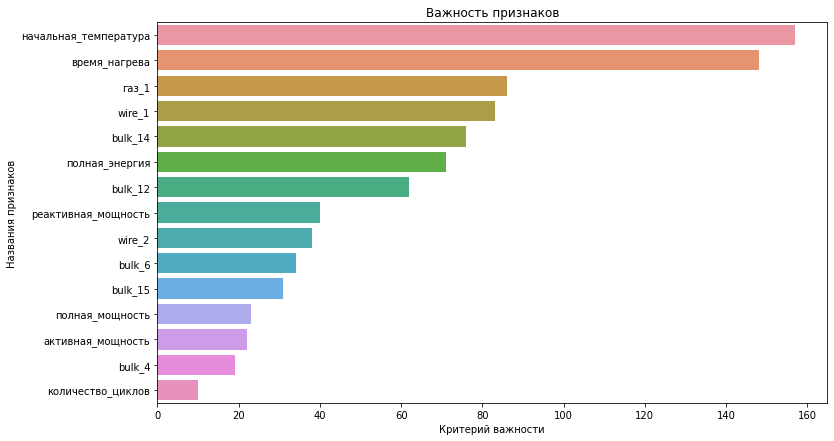

In [118]:
plt.figure(figsize=(12,7))

plot_data = pd.Series(randomized_search_LGBM
                      .best_estimator_
                      ._final_estimator
                      .feature_importances_,
                      index=X_test
                      .columns).sort_values(ascending=False)

sns.barplot(x=plot_data, y=plot_data.index)

plt.title('Важность признаков')
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

Проверим также важность признаков с помощью метода Шепли.

In [119]:
model = randomized_search_LGBM.best_estimator_.named_steps['models']

In [120]:
#Значения SHAP для модели черного ящика
explainer = shap.TreeExplainer(model)

In [121]:
shap_values = explainer(X_test)

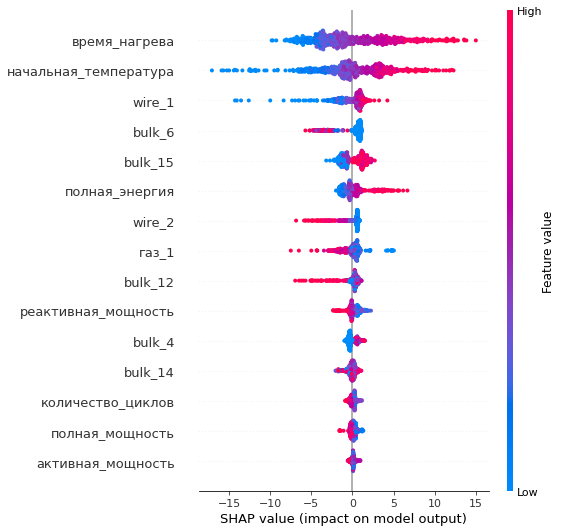

In [122]:
#суммарная оценка вклада каждого входящего признака для предсказания модели
shap.summary_plot(shap_values, X_test)

Видим, что и при использовании метода feature_importances и метода shap модель в качестве самых важных признаков принимает начальную температуру и время нагрева. 

**Промежуточный вывод**

Обучили несколько моделей:линейную модель, дерево решений и LGBMRegressor. 

Создали словари гиперпараметров для поиска по сетке.
Выбор лучшей на основе метрики — МАЕ. 

С помощью поиска по сетке и кросс-валидации получили лучшую модель с метрикой МАЕ на тренировочной выборке ниже пороговой для заказчика. 

Лучшая модель имеет следующие параметры - LGBMRegressor(max_depth=8, num_leaves=10, random_state=250825,
                               verbose=-1))

На тестовой выборке МАЕ также удовлетворяет требованиям заказчика.

При сравнении с DummyRegressor и при анализе метрики R2 все-таки делаем вывод, что модель имеет не самую лучшую обощающую и предсказательную способность. Работу модели можно улучшить введением дополнительных входящих признаков, а также выделения отдельной группы сплавов, имеющих повышенные значения добавок и продувок газом. Также мы помним из описательной статистики, что стандартное отклонение целевой переменной всего 11 с лишним единиц, тогда как сама температура измеряется тысячами. Соответственнго возможно не стоит тратиться на внедрение модели, а просто ориентироваться на среднее значение температуры.

При анализе важности признаков выявили, что для модели самыми важными признаками для принятия решений являлись данные по начальной температуре нагрева и общего времени нагрева.



<a id='section_id7'></a>
### Общий вывод по проекту.

**Цель проекта**

Цель проекта была предсказать конечную температуру сплава.
Целевая метрика - MAE (нужно получить не более 6.8 на тесте).

**Ход исследования**
Загрузили данные из семи датасетов, ознакомились с общей структурой данных. Проверили типы данных, пропуски и явные дубликаты. Провели промежуточную предварительную подготовку данных, а именно - привели данные о времени к типу дата-время. Привели все названия столбцов к общепринятому виду.


Изучили описательную статистику для каждого датафрейма за исключением данных о времени. Заменили явный выброс в данных по реактивной мощности (большое отрицательное значение) на медианное значение, а также удалили аномалии по начальной температуре. Все данные содержат выбросы, которые мы никак не обрабатывали, поскольку возможно эти значения являются элементами технологии, а не аномалиями. Следует заметить, что все выбросы, за исключением температуры нагрева размещены справа. Можно предположить, что возможно есть какие-то специальные сплавы, где по технологии и больше подача добавок и больше порция продувки газом. Также возможно, это нарушение технологии. Этот момент необходимо донести до заказчика и согласовать. Если это действительно какая-то отдельная группа сплавов, то вероятно будет разумно выделить ее в отдельную кагорту и провести отдельный анализ и обучение своей индивидуальной модели. 


Сдедали преобразования таблиц, добавили новые признаки, провели агрегацию, посчитали количество циклов нагрева, нашли начальную и конечную температуры нагрева, приняли решение какие данные не будем использовать для обучения моделей. Произвели объединение необходимых датасетов по ключу key методом inner, проконтролировали размер датасетов.


Провели исследовательский анализ финального датасета, посмотрели описательную статистику, корреляцию. 
По итогам исследования избавились от признаков с большим количеством пропусков и тех, которые не имеют зависимости от целевой переменной. Пропуски заполнили нулями. Обратили внимание на сдвиг всех распределений вправо и предположили, что существует отдельная категория сплавов с увеличинными подачами добавок и продувки газом.


Подготовили входящие признаки и целевую переменную, сделали разбивку на тренировочные и тестовые данные. Подготовили data preprocessor и итоговый пайп. 

Обучили несколько моделей:линейную модель, дерево решений и LGBMRegressor. 
Создали словари гиперпараметров для поиска по сетке.
Выбор лучшей на основе метрики — МАЕ. 
С помощью поиска по сетке и кросс-валидации получили лучшую модель с метрикой МАЕ на тренировочной выборке ниже пороговой для заказчика. 
Лучшая модель имеет следующие параметры - LGBMRegressor(max_depth=8, num_leaves=10, random_state=250825, verbose=-1))
На тестовой выборке МАЕ также удовлетворяет требованиям заказчика.

При сравнении с DummyRegressor и при анализе метрики R2 все-таки делаем вывод, что модель имеет не самую лучшую обощающую и предсказательную способность. Работу модели можно улучшить введением дополнительных входящих признаков, а также выделения отдельной группы сплавов, имеющих повышенные значения добавок и продувок газом. Также мы помним из описательной статистики, что стандартное отклонение целевой переменной всего 11 с лишним единиц, тогда как сама температура измеряется тысячами. Соответственнго возможно не стоит тратиться на внедрение модели, а просто ориентироваться на среднее значение температуры.

При анализе важности признаков выявили, что для модели самыми важными признаками для принятия решений являлись данные по начальной температуре нагрева и общего времени нагрева.


**Рекомендации для заказчика**
 - проверить корректность данных, и если имеются искажения в данных, понять почему это могло произойти (ошибка при выгрузке, ошибка оператора данных и т.д.)
 - провести аудит технологического процесса на наличие возможных нарушений
 - если нарушений нет, рассмотреть разделение данных на отдельные кагорты и внедрение двух моделей
 - для улучшения качества модели рассмотреть введение дополнительных входящих признаков
 - либо отказаться от внедрения модели и ориенитроваться на среднюю конечную температуру

